# Welcome to NameWeave - WaveNet

In this notebook we will try to complexify our neural network to get better results and generated names from our <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20(MLP)%20-%20Activations%2C%20Gradients%20%26%20Batch%20Normalization.ipynb">NameWeave (MLP) - Activations, Gradients & Batch Normalization</a> notebook.

But for starters we will have our code very similar to our <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20(MLP)%20-%20Activations%2C%20Gradients%20%26%20Batch%20Normalization.ipynb">NameWeave (MLP) - Activations, Gradients & Batch Normalization</a> notebook.

Also, remember how I left an intentional problem lurking under <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20(MLP)%20-%20Activations%2C%20Gradients%20%26%20Batch%20Normalization.ipynb">NameWeave (MLP) - Activations, Gradients & Batch Normalization</a> notebook?

I fixed it during this starter code, so hopefully you'll also be able to recognize what we have to be careful with...


# Installing Dependencies

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib

# Importing Libraries


In [2]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_15456\3082457058.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset

In [3]:
words = open("Datasets/Indian_Names.txt").read().splitlines()
words = [word.lower() for word in words]

In [4]:
len(words)

53982

# Building Vocabulary

In [5]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:", characters)
print("STOI:", stoi)
print("ITOS", itos)
# We define a common vocabulary size
vocabularySize = len(stoi)
print("Vocabulary Size:", vocabularySize)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary Size: 27


# Building Dataset

In [6]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


# Modular Block Definition

You will see that we previously had a generator object in this modular code...

This is for seed reproducability.

And we will only use a manual seeding directly into PyTorch using:
```python
torch.manual_seed(69420)
```

In [7]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []

# Neural Network Initialization - Weights, Biases & Parameters

In [8]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200
# Initializing the embedding look-up matrix
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength))
# Initializing the layers into a single list called 'layers', stacking them one after another
layers = [
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
]

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    layers[-1].gamma *= 0.1

# We initialize all the parameters
parameters = [embeddingLookUpMatrix] + [parameter for layer in layers for parameter in layer.parameters()]
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 12124


# Forward Pass

In [9]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 32

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1)

    # Check outputs after batch normalization layers
    for layer in layers:
        # We call the forward pass of each layer
        concatenatedEmbedding = layer(concatenatedEmbedding)
    loss = F.cross_entropy(concatenatedEmbedding, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2929
  10000/ 200000: 2.4449
  20000/ 200000: 1.7085
  30000/ 200000: 2.3984
  40000/ 200000: 1.8998
  50000/ 200000: 2.1423
  60000/ 200000: 1.8823
  70000/ 200000: 1.8821
  80000/ 200000: 2.2512
  90000/ 200000: 2.3865
 100000/ 200000: 2.0659
 110000/ 200000: 1.6045
 120000/ 200000: 1.8543
 130000/ 200000: 2.1539
 140000/ 200000: 1.6183
 150000/ 200000: 1.8724
 160000/ 200000: 1.8351
 170000/ 200000: 1.5911
 180000/ 200000: 1.8755
 190000/ 200000: 2.0474


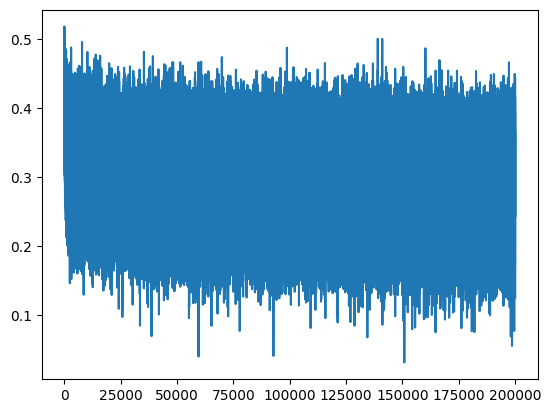

In [10]:
plt.plot(losses)

Our losses look pretty ugly and we will fix that in a second...

### Evaluating Losses

In [11]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    for layer in layers:
        concatenatedEmbedding = layer(concatenatedEmbedding)
    loss = F.cross_entropy(concatenatedEmbedding, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.897056221961975
Validation Loss:1.9188517332077026


# Sampling from the Neural Network

Now comes the main part...

I intentionally did not set the training attribute of `BatchNorm1d` layers to `False` last time.

First we have to understand that batch normalization behaves differently during training and inference. During training, batch normalization computes batch statistics (mean and variance) based on the current batch of data, which can sometimes lead to issues with small batch sizes or non-representative batches. However, during inference, it's common practice to use precomputed running statistics (accumulated during training) and fix the batch normalization layers to not update their statistics further.

By setting `layer.training = False` for `BatchNorm1d` layers during sampling, we effectively switch them to inference mode, ensuring that they use precomputed running statistics (such as the moving average ($\mu$) for mean and moving variance($\sigma^2$) for variance) and do not update their parameters (such as $\gamma$ and $\beta$, which are learnable parameters) during sampling.

So, if you're trying to pass in a single example of *context* into a `Batch-Normalization` layer which is in `Training` mode, we are going to end up estimating the `variance` of the batch.

So, what is the issue then? We are trying to estimate the `variance` in the `Batch-Normalization` layer in the first place...

Well, `variance` tries to look at the amount of *spread* in the data. So, `variance` of a single number, is `not-a-number` a.k.a `NaN` in PyTorch.

For example, if we have a very simple example:
```python
torch.var(torch.tensor([69.0]))
```

We get the result:
```python
tensor(nan)
```

In [12]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

for layer in layers:
    layer.training = False

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # We would create an output embedding that would be based on the block
        embedding = embeddingLookUpMatrix[torch.tensor([block])]
        concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
        # Inside the loop where layers are applied
        for layer in layers:
            concatenatedEmbedding = layer(concatenatedEmbedding)
        # Apply softmax
        probabilities = F.softmax(concatenatedEmbedding, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

prasenapraguruthrapa.
swaran.
arveeran.
dhy.
haranithusree.
sud.
kadtwaz.
ridapathindermitdalan.
chini.
wen.
sivani.
haran.
kala.
yothushan.
dheemalaimithasshan.
akshinod.
tha.
prama.
nila.
divthirampyi.


Now let's fix the loss graph first....

# Fixing Loss Graph

Let's recall what `losses` are first...

`losses` are nothing but a python list of floating point numbers.

So if we try to print the first `10` numbers from the list:
```python
losses[:10]
```
We get something like this:
```python
[0.517582893371582,
 0.5161539316177368,
 0.5183981657028198,
 0.5125000476837158,
 0.5141331553459167,
 0.5116288065910339,
 0.5155861377716064,
 0.5093725919723511,
 0.5093583464622498,
 0.5094155073165894]
```

We understand that we are calculating losses of mini-batches of only `32` examples, and we can get *very lucky and very unlucky* in any one of these batches, which eventually creates a very thick loss graph. Despite these fluctuations, over a large number of epochs, the trend in the loss graph typically demonstrates a gradual decrease, indicating the model's learning progress over time. To visualize this trend more effectively, we apply a `logarithmic transformation` to the `loss` values, *squashing* the steep curve into a smoother graph for better interpretation.

We also saw that each of our `losses` floating point numbers were stretched out across the number of `epochs` we had during forward pass.

Which means if we try to average these `losses` in short intervals of `epochs`, we will smooth out the representation of the *trend* in the `losses` over time...

Let's understand how we can do this...

For example if we take a tensor of the first `10` numbers we do something like this:
```python
torch.arange(10)
```
Which gives us:
```python
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

```

We understand that this is a `1` dimensional array.

But we can recall that we can `view` this array in `2` dimensions now...
```python
torch.arange(10).view(2, 5)
```
For which we get:
```python
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
```
Here we see that the first `10` numbers are now being *viewed* as a `2` by `5` array, where the first row consists of the first `5` elements and the second row consists of the `5` numbers right after that.

Similarly, we can also do:
```python
torch.arange(10).view(5, 2)
```
For which we get:
```python
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
```
Here we see that the first `10` numbers are now being *viewed* as a `5` by `2` array, where each row consists of `2` elements for `5` rows.

We can also recall that we can get the exact same output by using `-1` in place of one of these numbers to make python calculate what the other number must be in order to make the number of elements work out.

So for example, we have:
```python
torch.arange(10).view(-1, 5)
```
or
```python
torch.arange(10).view(2, -1)
```
For which we get:
```python
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
```
And we have:
```python
torch.arange(10).view(5, -1)
```
or
```python
torch.arange(10).view(-1, 2)
```
For which we get:
```python
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
```

So using the same logic we can use the same logic to first create a tensor out of the original python list `losses` and check the shape of it.

Using:
```python
torch.tensor(losses).shape
```
We get:
```python
torch.Size([200000])
```

We see that we have the floating point loss numbers for each of those number of `epochs`...

We can now use the `view` logic to let PyTorch figure out the number of rows using `-1` and use the columns arguement to specify the number of `intervals of epochs` we want to average out.

Let's say we want to average out `epochs` of `1000` intervals.

So now we can view our rows of `1000 epoch intervals` of `losses`:
```python
torch.tensor(losses).view(-1, 1000).shape
```
We get:
```python
torch.Size([200, 1000])
```

So we can average out all the rows using the `mean()` at dimension `1`...

So if we now check the shape:
```python
torch.tensor(losses).view(-1, 1000).mean(1).shape
```
And we see that we get the same number of rows:
```python
torch.Size([200])
```

So we can now easily plot this using:

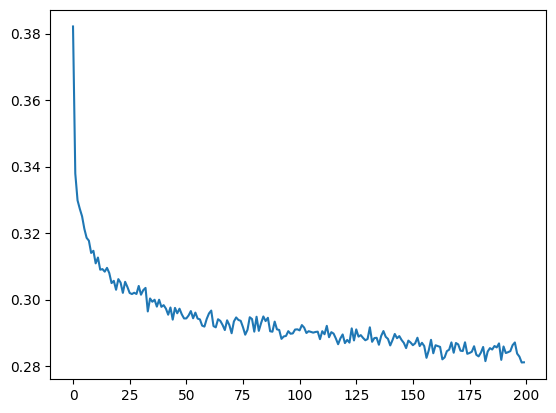

In [13]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

This smoothing doesn't eliminate the individual spikes and dips in the loss graph but provides a clearer picture of the overall trend by reducing the impact of those fluctuations...

Let's now move on to the next section...

# *PyTorch-ifying* Modular Code

You see how our modular blocks are still a little bit *gnarly* during the forward pass?

We use too many lines of code

For example, we use:
```python
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    
    for layer in layers:
        # We call the forward pass of each layer
        concatenatedEmbedding = layer(concatenatedEmbedding)
    loss = F.cross_entropy(concatenatedEmbedding, outputBatch)
```

You see how the `inputBatch`(s) are used to index into `embeddingLookUpMatrix`, but it is still outside of the `layers`, and in addition to that the `view()` operation is also outside of these `layers`.

Let's modularize this code by creating `layers` for these and we can add them to our `layers[]` list.

So we know that we need two things:
1. Embedding Layer
2. Flatten Layer

`Embedding` Layer is required for `embeddingLookUpMatrix` because we index into it using `inputBatch`. And `Flatten` Layer is required because we are effectively doing a *concatenation* operation for the sequence of embeddings we want to push through as an input, and stretches these embeddings into a single row of array, which is basically a **flatening** operation...

Now, not surprisingly, these `Embedding` and `Flatten` modules are already there in PyTorch block.

For example, the `Embedding` module is there:
```python
torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, _freeze=False, device=None, dtype=None)
```

We see that it takes a long list of arguements, but we would like to keep things simple and only have `num_embeddings` and `embedding_dim`.

And according to the documentation we see that:\
**Parameters**:
- **num_embeddings** (`int`) – size of the dictionary of embeddings
- **embedding_dim** (`int`) – the size of each embedding vector

Also, for example the `Flatten` module is there:
```python
torch.nn.Flatten(start_dim=1, end_dim=-1)
```

Once again we see that it takes a number of arguements but we are have our own custom *concatenation* operation to aid...

So let's now implement the modular blocks...

### Modular Block Definition

In [12]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class Flatten:
    # Concatenation operation in the forward pass : Similar to -> concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    def __call__(self, inputs):
        self.out = inputs.view(inputs.shape[0], -1)
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []

Now that we have this, we can start modifying our **initialization** to be a more simpler code...

Previously we had:
```python
# Initializing the embedding look-up matrix
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength))
# Initializing the layers into a single list called 'layers', stacking them one after another
layers = [
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
]
```
So now we can take out the line `embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength))` and the `Embedding` and `Flatten` layer to the `layers` list...

Like this:
```python
# Initializing the layers into a single list called 'layers', stacking them one after another
layers = [
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
]
```

Also during initialization we had the `parameters` as:
```python
# We initialize all the parameters
parameters = [embeddingLookUpMatrix] + [parameter for layer in layers for parameter in layer.parameters()]
```

But now we do not need to *special case* the `embeddingLookUpMatrix` because of the `parameters()` method implemented in our module block...

So now we have:
```python
# We initialize all the parameters
parameters = [parameter for layer in layers for parameter in layer.parameters()]
```

Let's now simplify the **forward pass**...


Previously we had:
```python
# Forward Pass (Mini-Batch)
embedding = embeddingLookUpMatrix[inputBatch]
concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    
for layer in layers:
    # We call the forward pass of each layer
    concatenatedEmbedding = layer(concatenatedEmbedding)
loss = F.cross_entropy(concatenatedEmbedding, outputBatch)
```

So now we can take out the lines `embedding = embeddingLookUpMatrix[inputBatch]` and `concatenatedEmbedding = embedding.view(embedding.shape[0], -1)` and put them into our layers...

So now we have:
```python
# Forward Pass (Mini-Batch)
for layer in layers:
    # We call the forward pass of each layer
    inputBatch = layer(inputBatch)
loss = F.cross_entropy(inputBatch, outputBatch)
```

Let's now implement it in our code...

### Neural Network Initialization - Weights, Biases & Parameters

In [13]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200

# Initializing the layers into a single list called 'layers', stacking them one after another
layers = [
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
]

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    layers[-1].gamma *= 0.1

# We initialize all the parameters
parameters = [parameter for layer in layers for parameter in layer.parameters()]
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 12124


### Forward Pass

We will for now insert a `break` at the end just to run the forward pass for the first iteration to make sure it runs properly and we can take it out later...

In [14]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 32

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    for layer in layers:
        # We call the forward pass of each layer
        inputBatch = layer(inputBatch)
    loss = F.cross_entropy(inputBatch, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

    break

      0/ 200000: 3.2929


Nice, so we do get an output and we can continue to *pytorchify* our code more...

## Further *Pytorch-ifiying* our code

Right now we are maintaining our code in a naked python list of `layers`.

We can also simplify this by introducing a concept of PyTorch `Containers`.

We are basically building `TORCH.NN` from scratch, and inside of `TORCH.NN`, there is a concept of `Containers`.

These `containers` are used for organizing layers into form of `lists` and `dictionationaries` and so on...

There is a `Container` within all the containers that have been implemented in PyTorch, known as `Sequential`. This `Sequential` container maintains a list of layers and passes a given input through all the layers, sequentially.

Which is the exact same thing that we have been doing in our `layers` list.

So let's implement our own `Sequential` class.

### Modular Block Definition

In [15]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class Flatten:
    # Concatenation operation in the forward pass : Similar to -> concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    def __call__(self, inputs):
        self.out = inputs.view(inputs.shape[0], -1)
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

### Neural Network Initialization - Weights, Biases & Parameters

Now we can start simplifying our code:

Previously we had:
```python
# Initializing the layers into a single list called 'layers', stacking them one after another
layers = [
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
]
```

Now we can have:
```python
# Initializing the model's sequential layers into a single module called model
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
])
```

Here we see that `layers` becomes a `model`, which is a notion of a *Module*.

See how I use the word *Module* a lot?

Well that's because, a **Module** is the base class for all the classes in PyTorch.

Also before we had:
```python
# We initialize all the parameters
parameters = [parameter for layer in layers for parameter in layer.parameters()]
```

Now, because we implemented the same within the `Sequential` class, we can have:
```python
# We initialize all the parameters
parameters = model.parameters()
```

So now we have:

In [16]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    layers[-1].gamma *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 12124


### Forward Pass

This time, we can also improve forward pass substantially...

That's because, we don't have to forward the inputs manually in a loop.

Previously we had:
```python
# Forward Pass (Mini-Batch)
for layer in layers:
    # We call the forward pass of each layer
    inputBatch = layer(inputBatch)
loss = F.cross_entropy(inputBatch, outputBatch)
```

Now we simply call the model using the input data(`inputBatch`):
```python
# Forward Pass (Mini-Batch)
logits = model(inputBatch)
loss = F.cross_entropy(logits, outputBatch)
```

In [17]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 32

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    logits = model(inputBatch)
    loss = F.cross_entropy(logits, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

    break

      0/ 200000: 3.6497


#### Evaluating Losses

So, similarly like the old code:
```python
# Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
embedding = embeddingLookUpMatrix[input]
concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
for layer in layers:
    concatenatedEmbedding = layer(concatenatedEmbedding)
loss = F.cross_entropy(concatenatedEmbedding, output)
```

We can have:
```python
logits = model(input)
loss = F.cross_entropy(logits, output)
```

In [14]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can now forward through layers to get the logits
    logits = model(input)
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:3.6893813610076904
Validation Loss:3.6842901706695557


Don't sweat on the losses too much, this was just the first epoch and our neural network is not trained until we remove the `break` in the forward pass.

### Sampling from the Neural Network

So previously we had:
```python
# We would create an output embedding that would be based on the block
embedding = embeddingLookUpMatrix[torch.tensor([block])]
concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
# Inside the loop where layers are applied
for layer in layers:
    concatenatedEmbedding = layer(concatenatedEmbedding)
# Apply softmax
probabilities = F.softmax(concatenatedEmbedding, dim=1)
```

Now we have:
```python
# Now we simply call the model on the context
logits = model(torch.tensor([block]))
# Apply softmax
probabilities = F.softmax(logits, dim=1)
```

In [18]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

for layer in model.layers:
    layer.training = False

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # Now we simply call the model on the context
        logits = model(torch.tensor([block]))
        # Apply softmax
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

pvcgrvloatsayltpegyglhntbttmkotwndch.
jpvxzmidcuvnmanf.
.
bnrkdfkfhvkqjhcypfpfyaqirfsewssnlvjkcgnpjnafof.
.
vuswvmkdkgxezoplmnkxyuowbdylnxbniapxblxbolfnzrcnyrnlw.
dtdcwrkdg.
o.
lspvrnjxpzrtwqvjlgkdnktvlolscyezaarqinlsxhjivfb.
.
nvcxzoadxzkcscraufozhphvpabosgnddguifwlhkwle.
rmefnadwkulfvudbaibnate.
.
wsbciikxsvbchwycyhamrkyvcvkjgklmcsyqdtakjufytlule.
nbruxkzrqnoutrmgezvrcrsjhidpxhtelbmiqul.
sssaeanffthjevnwkrjhavrbxanesphmv.
gajcpnutzaknayuficubvnkxzcipzsaivnlcwaeknlkbsyayyurwdtqcjhszdornrwpwdfuqjnrxhxoixioowfsryrurspkmoydimfpkm.
dbtfwjzgbepoub.
zrvikvshesszgjk.
bsqevdukg.


Once again, don't sweat on the outputs too much, this was just the first epoch and our neural network is not trained until we remove the `break` in the forward pass.

So let's re-run everything without the `break` and see where we are, and check new ways to introduce new ways to improve our code (for this notebook, `WaveNet`.

## Re-Running *PyTorch-ified* Code

### Modular Block Definition

In [19]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class Flatten:
    # Concatenation operation in the forward pass : Similar to -> concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    def __call__(self, inputs):
        self.out = inputs.view(inputs.shape[0], -1)
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

### Neural Network Initialization - Weights, Biases & Parameters

In [20]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False), BatchNorm1d(vocabularySize),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    layers[-1].gamma *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 12124


### Forward Pass

In [21]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 32

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    logits = model(inputBatch)
    loss = F.cross_entropy(logits, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.6497
  10000/ 200000: 2.4653
  20000/ 200000: 1.6796
  30000/ 200000: 2.3646
  40000/ 200000: 1.8944
  50000/ 200000: 2.0996
  60000/ 200000: 1.8235
  70000/ 200000: 1.9176
  80000/ 200000: 2.2351
  90000/ 200000: 2.4220
 100000/ 200000: 2.1087
 110000/ 200000: 1.5772
 120000/ 200000: 1.8115
 130000/ 200000: 2.1501
 140000/ 200000: 1.6242
 150000/ 200000: 1.9227
 160000/ 200000: 1.8169
 170000/ 200000: 1.6318
 180000/ 200000: 1.9186
 190000/ 200000: 2.0971


#### Evaluating Losses

In [22]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can now forward through layers to get the logits
    logits = model(input)
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.8957682847976685
Validation Loss:1.9175524711608887


Just for a reminder, let's save the losses so that we can compare them later...

For now we get:
```python
Training Loss:1.8957682847976685
Validation Loss:1.9175524711608887
```

### Sampling from the Neural Network

In [23]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

for layer in model.layers:
    layer.training = False

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # Now we simply call the model on the context
        logits = model(torch.tensor([block]))
        # Apply softmax
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

prasenap.
saktithrapa.
swar.
pia.
veeran.
dhy.
haranithusree.
sudhandhubh.
ridapathini.
ummudalan.
jaipuswanishani.
vasun.
swada.
yothushan.
dheemalaimithasshan.
akokilan.
tha.
prama.
nila.
divanjalehy.


# WaveNet - Overview

See how are losses, that we got from the above implementation are pretty similar to each other, which means that we are not overfitting too much on this task and we can make additional progress in our performance by scaling up everything and making bigger and deeper.

Now currently we are using this a version of this architecture:

![A Neural Probabilistic Language Model](https://miro.medium.com/v2/resize:fit:1400/1*EqKiy4-6tuLSoPP_kub33Q.png)

The problem with this architecture is that, we are crushing may too much information too quickly at the very beginning in a single hidden layer...

Which means, that even if we tried to make this network deeper by introducing new hidden layers to the neural network, it would make no sense to miss out on the information that we keep missing out on the *squashed* embeddings of the characters.

Instead we would want our network to look a lot more like this paper -><a href="https://arxiv.org/abs/1609.03499">WaveNet: A Generative Model for Raw Audio</a>:
![WaveNet: Architecture](ExplanationMedia/Images/Dilated_Masked_Convolutions.png)

You see how when we are trying to predict the next character in a sequence, it is a function of the *previous* characters that feed in, but these characters are not crushed into a single layer (for which we have a sandwich like our current approach), instead they are crushed slowly.

So we take two characters and *fuse* them into a sort of like a **bigram** representation and we do that for all the characters **consecutively**. And then we take the bigrams and *fuse* those bigrams into sort of like a *bi-bigram* 😂 (4 character level chuncks), and then we fuse that again, ultimately creating a *tree-like* hierarchical structure of the neural network and we fuse the information of the previous context **slowly** as we go deeper into the neural network.

Now in the WaveNet's case, this is a representation of **Visualization of a stack of dilated causal convolutional layers**.

Scared?

Don't get scared by the name, the idea behind it is actually very simple, and is an implementation detail to make everything very fast, and we will be discussing it later. But let's just get the basic idea of how this works, which is this *progressive-fusion* of information.

Which means that we want to make the neural network deeper, and at each level we want to only fuse two consecutive elements.

Now even though our already implemented network might not give us good results by making it deeper, I want to re-run the network just for the sake of education that we are not missing out on anything by **increasing the `blockSize`** to `8` and save the losses for later comparison...

So let's do that now...

## Re-running old neural network with bigger `blockSize`

### Building Dataset

Here I changed the code from:
```python
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
```
To this:
```python
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 8
```

In [6]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 8
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


### Modular Block Definition

In [8]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class Flatten:
    # Concatenation operation in the forward pass : Similar to -> concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    def __call__(self, inputs):
        self.out = inputs.view(inputs.shape[0], -1)
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

### Neural Network Initialization - Weights, Biases & Parameters

Here I also cleaned the unnecessary `BatchNorm1d(vocabularySize)` layer, because it was not required.

In order to change it I had to change the `layers[-1].gamma *= 0.1` to `model.layers[-1].weights *= 0.1` because our last layer is a linear layer and it does not have the `gamma` parameter.

In [9]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    Flatten(),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    model.layers[-1].weights *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 22070


We also see that the number of parameters have increased from `12124` to `22070` because there is a lot more context feeding into the network now...

### Forward Pass

In [10]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 32

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    logits = model(inputBatch)
    loss = F.cross_entropy(logits, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2920
  10000/ 200000: 2.4085
  20000/ 200000: 2.1335
  30000/ 200000: 2.4298
  40000/ 200000: 1.9382
  50000/ 200000: 1.8395
  60000/ 200000: 1.6629
  70000/ 200000: 2.1228
  80000/ 200000: 2.3765
  90000/ 200000: 1.8921
 100000/ 200000: 1.6170
 110000/ 200000: 1.7706
 120000/ 200000: 1.8046
 130000/ 200000: 1.7374
 140000/ 200000: 1.7751
 150000/ 200000: 1.5593
 160000/ 200000: 1.7462
 170000/ 200000: 1.5239
 180000/ 200000: 2.2582
 190000/ 200000: 1.9832


#### Evaluating Losses

In [11]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can now forward through layers to get the logits
    logits = model(input)
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.7707616090774536
Validation Loss:1.81971275806427


Original Loss:
```python
Training Loss:1.8957682847976685
Validation Loss:1.9175524711608887
```

Increasing `blockSize` Loss:
```python
Training Loss:1.7707616090774536
Validation Loss:1.81971275806427
```

### Sampling from the Neural Network

In [12]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 8
# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

for layer in model.layers:
    layer.training = False

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # Now we simply call the model on the context
        logits = model(torch.tensor([block]))
        # Apply softmax
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

gicharadhan.
dupsada.
anhiyaa.
achen.
nikha.
advidhi.
thanujlyar.
arathayan.
sheshika.
jyotinika.
kosaladhasvi.
ayarthi.
nathina.
ralarajan.
dhearana.
thulasi.
maruleen.
saaranth.
mesilenthan.
divashni.


Seems like we are making progress just by increasing the `blockSize`, but now that we understand that this is still not helping us, let's implement the **WaveNet**.

## Implementing **WaveNet**

### Idea behind implementing **WaveNet**

Let's take an example and try to work out how we want our **WaveNet** neural network to behave during the forward pass...

If we take `4` random indeces from our entire `trainingInputs` dataset, we would generally pick out the indices like:
```python
indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(4,))
```
The code generates a 1-dimensional tensor (`indexes`), where, `low=0` specifies the lowest integer to be generated (inclusive), `high=trainingInputs.shape[0]` specifies the highest integer to be generated (inclusive), `size=(4,)` specifies the size of the output tensor to be generated, which in this case, it's a `1-dimensional tensor` with `4` elements.

So if we look at the `indexes` now, we get:
```python
tensor([185709, 297874,  24823,  11069])
```
We can now use these `indexes` to get our `examples` for input using:
```python
inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
```
Where `inputBatch` and `outputBatch` look like:
```python
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  4, 18,  9, 19,  8, 25],
        [ 0,  0,  0,  0, 19,  1,  4,  8]])
tensor([19,  8,  1, 21])       
```
We understand that we can simply now use our already implemented forward pass to forward the model using:
```python
logits = model(inputBatch)
```
If we check the shape of our `inputBatch` we get:
```python
torch.Size([4, 8])
```
And if we check the shapes of the output of each layer:
```python
model.layers[0].out.shape # Embedding Layer
model.layers[1].out.shape # Flatten Layer
model.layers[2].out.shape # Linear Layer
```
We get:
```python
torch.Size([4, 8, 10])
torch.Size([4, 80])
torch.Size([4, 200])
```

Getting confused?

I got you...

Let's look at it in an illustrative way:

![Before Wave Net](ExplanationMedia/Images/BeforeWaveNetNetwork.png)
> If the image is way too small to look at, the images are stored in the ExplanationMedia>Images folder for this repository.

#### Understanding Linear Transformation

Let's understand how the linear transformation inside our `Linear Layer` happens for our small example...

If we look back at our modular block for `__call__()` for our `Linear` module, we have:
```python
# Defines how we forward pass these layers which is (y = wx + b)
def __call__(self, inputs):
    # (w*x)
    self.out = inputs @ self.weights
    # Checking if we have a bias
    if self.biases is not None:
        # (wx) + b
        self.out += self.biases
    # We return (y = wx + b)
    return self.out
```

It looks something like this:
```python
torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)
```

$$
\underbrace{\underbrace{\text{torch.randn(4, 80)} @ \text{torch.randn(80, 200)}}_{\text{[4, 200]}} + \text{torch.randn(200)}}_{\text{[4, 200]}}
$$

Now let me show you something pretty interesting...

This same **multiplication** doesn't have to be 2-dimensional. The matrix multiplication operator in PyTorch ($@$) is quite powerful. In face, we can actually pass higer dimensional tensors and everything works just fine.

For example, the same line could be used to pass higher dimensional tensors:
```python
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
```
And we get:
```python
torch.Size([4, 5, 200])
```
And again
```python
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
```
And we get:
```python
torch.Size([4, 5, 2, 200])
```
And suddenly we see the pattern that, the matrix multiplication operator ($@$) only works on the last dimension, which in our case is `80` and the dimensions specified before it are left unchanged and treated as batch dimensions. In other words, we can have multiple batch dimensions and in parallel over all those dimensions, we end up doing the matrix multiplication over the last dimension.

Suddenly this becomes very convenient because, we can now use that in our neural network now...


Remember how we had our block of `8` characters coming in as an input for a single example?
```python
A B C D E F G H
```
It gets flattened out into a large vector. Instead we want to group these:
```python
(A B) (C D) (E F) (G H)
```
Which effectively means, all of these characters need to be flattened out in **parallel** and then multiplied by a weight matrix. Which leads us to introduce a batch dimension.

So, we want to process all of these **bigram groups** in the `4` batch dimensions of an individual example, and also over the actual batch of all the examples...

So let's see how that works...

Right now what happens in our example is:
```python
torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)
```

$$
\underbrace{\text{torch.randn(4, 80)}}_{\text{Input Examples}} \text{ @ } \underbrace{\text{torch.randn(80, 200)}}_{\text{Weights}} + \text{torch.randn(200)}
$$

1. We don't want a `(4, 80)` tensor now. We rather want a tensor which separates flattened out embeddings into groups for `4` bigrams now. Which means we want something like a `(4, 4, 20)`. (`4` examples of `4` bigram groups, each one having a `10` dimensional embedding)
2. Now because we discussed that the matrix multiplication only works on the last dimension, so instead of having a weights matrix of `(80, 200)` we will now have a weights matrix of `(20, 200)`

Which effectively tells us, instead of having a line like this during the linear transformation:
```python
torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)
```
We would have an expression of something like this:
```python
torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)
```

Which tells us to change the `Flatten Layer` such that it outputs a `(4, 4, 20)` instead of a `(4, 80)` tensor (Similar to a concatenation operation)...

So let's do that...

#### Understanding Flatten Transformation

Let's understand what happens to the inputs before and after the `Flatten Layer`.

If we look back at our modular block for `__call__()` for our `Flatten` module, we have:
```python
# Concatenation operation in the forward pass : Similar to -> concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
def __call__(self, inputs):
    self.out = inputs.view(inputs.shape[0], -1)
    return self.out
```
It looks something like this:
```python
inputsBeforeFlatten = torch.randn([4, 8, 10])
inputsAfterFlatten = inputsBeforeFlatten.view(inputsBeforeFlatten.shape[0], -1)
```
$$
\underbrace{\text{inputsAfterFlatten}}_{\text{[4, 80]}} = \underbrace{\text{inputsBeforeFlatten}}_{\text{[4, 8, 10]}}\text{.view(inputsBeforeFlatten.shape[0], -1)}
$$

Now let me show you something interesting once again...

Let's take for example `10` numbers like this:
```python
torch.arange(10)
```
So we get something like this:
```python
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
```
If you remember *slicing* in python correctly you'd probably remember that we can slice the even parts in the steps of `2` like this:
```python
torch.arange(10)[::2]
```
To get:
```python
tensor([0, 2, 4, 6, 8])
```
And we get all the odd parts in the steps of `2` starting at `1`, like this:
```python
torch.arange(10)[1::2]
```
To get:
```python
tensor([1, 3, 5, 7, 9])
```
Remembering this, we can now use this in our logic...

Remember how we want our `Flatten Layer` to output a `(4, 4, 20)` tensor instead of a `(4, 80)` tensor when it gets an input of `(4, 8, 10)` tensor?

In other words,\
The inputs for this *toy* example are `4` examples of `8` characters in a block, each one having a `10` dimensional embedding. \
Which instead of having each of these `4` examples stretching their corresponding `10` dimensional embeddings without any bigram groups into a single row, \
we now want an output tensor with `4` examples of `4` bigram groups, each one having a `20` dimensional embedding.


So what better way is it to use our old *odd and even* slicing trick to pick out the `odd` characters in a block and `even` characters in a block like this:
```python
inputsBeforeFlatten[:, ::2, :], inputsBeforeFlatten[:, 1::2, :] 
```
$$
\underbrace{inputsBeforeFlatten[:, ::2, :]}_{Even Parts}, \underbrace{inputsBeforeFlatten[:, 1::2, :]}_{Odd Parts}
$$
Which essentially does something like this for each example:
```python
example = ['A', 'I', 'N', 'D', 'R', 'I', 'L', 'A']

oddParts = ['I', 'D', 'I', 'A']
evenParts = ['A', 'N', 'R', 'L']
```

We now understand that each of these characters have their own `10` dimensional embeddings.

And we can now use these odd parts and even parts to separate out the characters and use them as groups of two in parallel by using a concatenation operation along the dimension of the embeddings (which is `2`), like this:
```python
outputsAfterFlatten = torch.cat((inputsBeforeFlatten[:, ::2, :], inputsBeforeFlatten[:, 1::2, :]), dim=2)
```
Which gives us an output like this:
```python
# Resulting tensor
tensor([[[*, *, *, *, *, *, *, *, *, *],  # 'A' embedding (evem)
         [*, *, *, *, *, *, *, *, *, *],  # 'N' embedding (even)
         [*, *, *, *, *, *, *, *, *, *],  # 'R' embedding (even)
         [*, *, *, *, *, *, *, *, *, *],  # 'L' embedding (even)
         [*, *, *, *, *, *, *, *, *, *],  # 'I' embedding (odd)
         [*, *, *, *, *, *, *, *, *, *],  # 'D' embedding (odd)
         [*, *, *, *, *, *, *, *, *, *],  # 'I' embedding (odd)
         [*, *, *, *, *, *, *, *, *, *]], # 'A' embedding (odd)
        [[...]], # Example 2
        [[...]], # Example 3
        [[...]]  # Example 4
       ])
```

Remember, this may not look like the ideal thing like the diagram we saw earlier for **WaveNet**, but we want something to act like a bigram group for all the examples in parallel. And this is the kind of output that we want.

But it also turns out that we can do the exactly same thing with `view()` from PyTorch and get the same shape we have now if we request the shape to be from `(4, 8, 10)` to `(4, 4, 20)`, like this:
```python
inputsBeforeFlatten = torch.randn([4, 8, 10]) # (4 examples of 8 characters in a block, each one having a 10 dimensional embedding)
outputsAfterFlatten = inputsBeforeFlatten.view(4, 4, 20) # (4 examples of 4 bigram groups, each group having a concatenated 20 dimensional embedding)
```
So now we can check `inputsAfterFlatten == outputsAfterFlatten` we want to check if they are the same, **element wise**, otherwise we can check using 
`torch.all(input) → Tensor` (which tests if all elements in `input` evaluate to `True`), like this:
```python
(inputsAfterFlatten == outputsAfterFlatten).all()
```
We get:
```python
tensor(True)
```

So long story short, we can simple use `view()` from PyTorch to change the tensor to whatever way we want it to be...

For now we want out initialize a `groups` inside `Flatten`. But the moment we do this we start to depart from the original implementation of `TORCH.FLATTEN` from PyTorch. So it's better to use a different name for the module like `ConsecutiveFlatten` that flattens only the *consecutive* elements based on `groups`.

Here's the original `Flatten` from PyTorch as a reminder:
```python
torch.flatten(input, start_dim=0, end_dim=-1) → Tensor
```
**Parameters**:
- **input** (`Tensor`) – the input tensor.
- **start_dim** (`int`) – the first dim to flatten
- **end_dim** (`int`) – the last dim to flatten

Now, we want our `ConsecutiveFlatten` to use these `groups` parameter to calculate a lot of things.

Remember how for our *toy* example, the inputs of `(4, 8, 10)` become outputs of `(4, 4, 20)`?

We can now use these `groups` to calculate the other dimensions as well for the outputs like this:\
Assuming that we need groups of `2` we can now determine:
$$
\displaylines{
\text{If, groups} = 2 \\
(4, 4, 20) \implies (4, \frac{8}{groups}, 10 * groups) \\
(4, 4, 20) \implies (4, -1, 10 * groups)
}
$$
Here `-1` is to automatically determine the bigram groups of outputs. But I like to see error messages, and rather don't like the use of `-1`, so I'd rather leave the implementation to $\frac{8}{groups}$...

But once again $\frac{8}{groups}$ can create problems in further layers...

How so? Let's take an example:

Suppose we have an input of say size `(2, 2, 4)` and we specify the groups to be `2`, then:
$$
\displaylines{
\text{If, groups} = 2 \\
(2, \frac{2}{groups}, 4 * groups) \implies (2, 1, 8)
}
$$
See how we can get a *spurious* dimension `1` as an output? Sending this as an input to the next layer can create performance problems to further calculate and index into the tensor. So we need to have a `torch.squeeze()` to squeeze out dimensions with `1`, but once again we want to be as specific as possible, so we would specify the exact dimension that is creating the problem in the first place, which is `1`...

So we can now move ahead and modify our `Flatten` to make it `ConsecutiveFlatten` now...

#### Editing Modular Block `Flatten` to make it `ConsecutiveFlatten`

In [7]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class ConsecutiveFlatten:
     # Constructor to initialize the number of groups
    def __init__(self, groups):
        # Initializing the groups 
        self.groups = groups
    # Concatenation operation in the forward pass : Flatten in groups
    def __call__(self, inputs):
        # Takes out each dimension from the inputs
        batch, charactersInBlock, embeddings = inputs.shape
        # Views as the desired group size
        outputs = inputs.view(batch, charactersInBlock//self.groups, embeddings*self.groups)
        # Checks if dimension 1 creates a spurious dimension
        if outputs.shape[1] == 1:
            # Squeezes out the dimension 1 to keep it from creating a spurious dimension
            outputs = outputs.squeeze(dim=1)
        self.out = outputs
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

We can now test it out on our *toy* example:

#### Testing `ConsecutiveFlatten` on our *toy-example*

Remember, for now we will keep the `groups` to current `blockSize`, because we understand that taking the groups of the maximum number the group can have divides the groups to individual elements, ultimately recalling the previous behaviour for our case...

In [15]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    ConsecutiveFlatten(groups=blockSize),
    Linear(embeddingFeatureSpaceLength * blockSize, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(             numberOfHiddenLayerNeurons,             vocabularySize, bias=False),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    model.layers[-1].weights *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 22070


In [16]:
indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(4,))
inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
logits = model(inputBatch)
print(inputBatch.shape)
inputBatch

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  0,  7, 15,  7],
        [ 0,  0,  0,  0,  0,  0,  0, 16]])

I have also added a small code snippet to check the shapes of the outputs after each layer:

In [17]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", layer.out.shape)

Embedding : torch.Size([4, 8, 10])
ConsecutiveFlatten : torch.Size([4, 80])
Linear : torch.Size([4, 200])
BatchNorm1d : torch.Size([4, 200])
Tanh : torch.Size([4, 200])
Linear : torch.Size([4, 27])


We see that the shapes work out fine after every single layer and its output...

Now, let's try to restructure the layer initialization for the `model` and instead of keeping `groups` to current `blockSize`, let's keep it in groups of `2` such that we can have the hierarchy we expect from the very first intention of the **WaveNet**...

But now we have to also be careful because, simply specifying groups of `ConsecutiveFlatten` might change the inputs of `Linear` as well, because right now we if we feed in a `4, 4, 20` output of `ConsecutiveFlatten` to a `Linear` layer that expects the inputs of size `embeddingFeatureSpaceLength * blockSize` which evaluates to `80`, its not going to work out...

Instead, we need to modify these `fan-in`s of the `Linear` layers to be `embeddingFeatureSpaceLength * groups` which evaluates to a concatenated `20` dimensional embedding as an input for the first layer, and the later `Linear` layers to be `numberOfHiddenLayerNeurons * groups` to do the similar operation...

After we have these implemented, we can now chain these entire layers just fine...

So let's do this now:

In [18]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 200
groups = 2

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    # Bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(embeddingFeatureSpaceLength * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(numberOfHiddenLayerNeurons, vocabularySize, bias=False),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    model.layers[-1].weights *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 170870


We suddenly see that we have a much bigger `model`...

In [19]:
indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(4,))
inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
logits = model(inputBatch)
print(inputBatch.shape)
inputBatch

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0, 10,  1, 14,  9, 12],
        [ 0,  0, 13,  1,  1, 14,  9, 19],
        [ 0,  0, 10,  1, 14,  5, 20,  8]])

In [20]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", layer.out.shape)

Embedding : torch.Size([4, 8, 10])
ConsecutiveFlatten : torch.Size([4, 4, 20])
Linear : torch.Size([4, 4, 200])
BatchNorm1d : torch.Size([4, 4, 200])
Tanh : torch.Size([4, 4, 200])
ConsecutiveFlatten : torch.Size([4, 2, 400])
Linear : torch.Size([4, 2, 200])
BatchNorm1d : torch.Size([4, 2, 200])
Tanh : torch.Size([4, 2, 200])
ConsecutiveFlatten : torch.Size([4, 400])
Linear : torch.Size([4, 200])
BatchNorm1d : torch.Size([4, 200])
Tanh : torch.Size([4, 200])
Linear : torch.Size([4, 27])


Looking at this, when we verify the shapes, we see that all the shapes work out fine, but now we also see that `BatchNorm1d` runs out of the box without creating any errors.

We still need to verify `BatchNorm1d`, and if it works like the way it should...

But before we do that, let's run our neural network once to evaluate the losses once more, just to keep score, and then we can keep fixing bugs for the `BatchNorm1d`...

### Running **WaveNet** for implemented `ConsecutiveFlatten`

Before we run this, I want to specify that I will be changing the `numberOfHiddenLayerNeurons` from `200` to `68` in order to make the architecture parameters to be the same as our old neural network, so that we have the same amount of capacity as the neural network to check if we are properly utilizing these parameters in a more efficient architecture as a comparison.

And I have also increased the batchSize from `32` to `128`, such that it does not lead to numerical instability like we discussed in our previous notebooks...

#### Building Dataset

In [7]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 8
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


#### Modular Block Definition

In [8]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Initializing mean of current batch of inputs along dimension 0 and keeping the dimensions
            input_mean = inputs.mean(0, keepdim=True)
            # Initializing variance of current batch of inputs along dimension 0 and keeping the dimensions
            input_variance = inputs.var(0, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class ConsecutiveFlatten:
     # Constructor to initialize the number of groups
    def __init__(self, groups):
        # Initializing the groups 
        self.groups = groups
    # Concatenation operation in the forward pass : Flatten in groups
    def __call__(self, inputs):
        # Takes out each dimension from the inputs
        batch, charactersInBlock, embeddings = inputs.shape
        # Views as the desired group size
        outputs = inputs.view(batch, charactersInBlock//self.groups, embeddings*self.groups)
        # Checks if dimension 1 creates a spurious dimension
        if outputs.shape[1] == 1:
            # Squeezes out the dimension 1 to keep it from creating a spurious dimension
            outputs = outputs.squeeze(dim=1)
        self.out = outputs
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

#### Neural Network Initialization - Weights, Biases & Parameters

In [9]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 68
groups = 2

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    # Bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(embeddingFeatureSpaceLength * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(numberOfHiddenLayerNeurons, vocabularySize, bias=False),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    model.layers[-1].weights *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 22370


#### Forward Pass

In [11]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 128

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    logits = model(inputBatch)
    loss = F.cross_entropy(logits, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2710
  10000/ 200000: 1.7531
  20000/ 200000: 1.9206
  30000/ 200000: 1.8199
  40000/ 200000: 1.8127
  50000/ 200000: 1.7926
  60000/ 200000: 1.7219
  70000/ 200000: 1.6272
  80000/ 200000: 1.8719
  90000/ 200000: 1.8040
 100000/ 200000: 1.7283
 110000/ 200000: 1.9233
 120000/ 200000: 2.0418
 130000/ 200000: 1.8635
 140000/ 200000: 1.7831
 150000/ 200000: 1.7067
 160000/ 200000: 1.7407
 170000/ 200000: 1.6656
 180000/ 200000: 1.7841
 190000/ 200000: 1.5795


##### Evaluating Losses

In [12]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can now forward through layers to get the logits
    logits = model(input)
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.720413088798523
Validation Loss:1.7969316244125366


Original Loss:
```python
Training Loss:1.8957682847976685
Validation Loss:1.9175524711608887
```

Increasing `blockSize` Loss:
```python
Training Loss:1.7707616090774536
Validation Loss:1.81971275806427
```

Implementing WaveNet for `ConsecutiveFlatten` Loss:
```python
Training Loss:1.720413088798523
Validation Loss:1.7969316244125366
```

### Fixing `BatchNorm1d` for implemented `ConsecutiveFlatten`

Let's recall the `BatchNorm1d` layer code implementation first:

```python
class BatchNorm1d:
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = torch.ones(dimensions)
        self.beta = torch.zeros(dimensions)
        # Buffers
        self.running_mean = torch.zeros(dimensions)
        self.running_variance = torch.ones(dimensions)
        self.training = training
    def __call__(self, inputs):
        if self.training:
            input_mean = inputs.mean(0, keepdim=True)
            input_variance = inputs.var(0, keepdim=True)
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
```

Now let's try to think through the `inputs` and `outputs` of a `BatchNorm1d` layer by looking at the shapes of inputs...

Let's try to take an example...

Right now, the shapes of outputs look something like this:
```python
Embedding : torch.Size(32, 8, 10)
ConsecutiveFlatten : torch.Size(32, 4, 20)
Linear : torch.Size(32, 4, 68)
BatchNorm1d : torch.Size(32, 4, 68)
Tanh : torch.Size(32, 4, 68)
ConsecutiveFlatten : torch.Size(32, 2, 136)
Linear : torch.Size(32, 2, 68)
BatchNorm1d : torch.Size(32, 2, 68)
Tanh : torch.Size(32, 2, 68)
ConsecutiveFlatten : torch.Size(32, 136)
Linear : torch.Size(32, 68)
BatchNorm1d : torch.Size(32, 68)
Tanh : torch.Size(32, 68)
Linear: torch.Size(32, 27)
```

Let's take the inputs for the first `BatchNorm1d` layer, which is the output of the `Linear` layer...

Right now the forward pass looks something like this:
```python
inputs = torch.randn(32, 4, 68)
input_mean = inputs.mean(0, keepdim=True)
input_variance = inputs.var(0, keepdim=True)
input_hat = (inputs - input_mean) / torch.sqrt(input_variance + 1e-5)
input_hat.shape
```
And we see that the output broadcasts properly:
```python
torch.Size([32, 4, 68])
```

Still not understandable?

Okay let's break it down with illustrations...

Previously we had something like this *toy* example:\
![BatchNormApproachBeforeWaveNet](ExplanationMedia/Images/BatchNormApproachBeforeWaveNet.png)

Here we had a batch of `4` examples, with let's say `6` dimensional embeddings, and we calculated mean across all the examples in a batch.

But now we have something like this:
![BatchNormBeforeFixingWaveNet](ExplanationMedia/Images/BatchNormBeforeFixingWaveNet.png)

Here, we see that we mean across only the batch of examples, which is not what we want...

Rather we also need to do mean across all the bigram groups like this (treat the bigram groups as a **batch-dimension** as well):
![BatchNormAfterFixingWaveNet](ExplanationMedia/Images/BatchNormAfterFixingWaveNet.png)

Turns out we can do this pretty easily when we look at the documentation of `TORCH.MEAN` from PyTorch, we have:

```python
torch.mean(input, *, dtype=None) → Tensor
```

**Parameters**:
- **input** (`Tensor`) – the input tensor.
- **dim** (`int` or `tuple of ints`) – the dimension or dimensions to reduce.
- **keepdim** (`bool`) – whether the output tensor has dim retained or not.

**Keyword Arguments**:
- **dtype** (`torch.dtype`, *optional*) – the desired data type of returned tensor. If specified, the input tensor is casted to dtype before the operation is performed. This is useful for preventing data type overflows. Default: None.
- **out** (`Tensor`, *optional*) – the output tensor.

We see that instead of just an `int` we can specify a `tuple of ints` to reduce over dimensions, so we can easily perform reduction over the dimensions specified in the tuple...

For us, it will be dimension `0` and `1`...

But also see how in the later layers, the `BatchNorm1d` performs the batch normalization on `2` dimensional inputs as well, so we need to handle different calculations for different dimensions as well...

And it seems pretty straight forward it seems... We simply check if the inputs are of shape of `2` dimensions then we pass in `dim=0` into the `input_mean` and `input_variance` otherwise we pass in `dim=(0, 1)` if we get a three dimensional input, otherwise it will throw an error which is good in my opinion...

But the moment we think of this we should also know that, even here we start departing from the original `BATCHNORM1D` from PyTorch.

Why?

Because if we look at the documentation of `BATCHNORM1D`, it states the shapes should be:
- **Input**: `(N,C)` or `(N,C,L)`, where `N` is the batch size, `C` is the number of features or channels, and `L` is the sequence length
- **Output**: `(N,C)` or `(N,C,L)` (same shape as input)

Which means `BATCHNORM1D` from PyTorch reduces the dimensions `(0, 2)` instead of `(0, 1)`, because our `BatchNorm1d` expects `(N,C)` or `(N,L,C)`. 

Honestly I like the expression `(0, 1)` instead of `(0, 2)` so we will keep the implemenation as we have done till now...

Let's now edit our modular block for `BatchNorm1d`...

In [1]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Checking if the inputs are 2-dimensional
            if inputs.ndim == 2:
                # Setting the dimension to reduce over to 0
                dimensions = 0
            # Checking if the inputs are 3-dimensional
            elif inputs.ndim == 3:
                # Setting the dimension to reduce over to (0, 1)
                dimensions = 0
            # Initializing mean of current batch of inputs along dimensions and keeping the dimensions
            input_mean = inputs.mean(dimensions, keepdim=True)
            # Initializing variance of current batch of inputs along dimensions and keeping the dimensions
            input_variance = inputs.var(dimensions, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class ConsecutiveFlatten:
     # Constructor to initialize the number of groups
    def __init__(self, groups):
        # Initializing the groups 
        self.groups = groups
    # Concatenation operation in the forward pass : Flatten in groups
    def __call__(self, inputs):
        # Takes out each dimension from the inputs
        batch, charactersInBlock, embeddings = inputs.shape
        # Views as the desired group size
        outputs = inputs.view(batch, charactersInBlock//self.groups, embeddings*self.groups)
        # Checks if dimension 1 creates a spurious dimension
        if outputs.shape[1] == 1:
            # Squeezes out the dimension 1 to keep it from creating a spurious dimension
            outputs = outputs.squeeze(dim=1)
        self.out = outputs
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

Let's now try to run the WaveNet with fixed `BatchNorm1d` now...

### Running **WaveNet** for implemented `ConsecutiveFlatten` and `BatchNorm1d`

#### Building Dataset

In [12]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 8
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


#### Modular Block Definition

In [13]:
class Linear:
    # Constructor to initialize the weights and biases
    def __init__(self, fan_in, fan_out, bias=True):
        # We initialize the weights using fan-in and fan-out and use the kaiming initialization which is the square root of fan-in
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # We initilize the biases using fan-out and set them to 0 values if bias is set to True else we set it to None
        self.biases = torch.zeros(fan_out) if bias else None
    # Defines how we forward pass these layers which is (y = wx + b)
    def __call__(self, inputs):
        # (w*x)
        self.out = inputs @ self.weights
        # Checking if we have a bias
        if self.biases is not None:
            # (wx) + b
            self.out += self.biases
        # We return (y = wx + b)
        return self.out
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # If bias is there return (w*x + b) else return (w*x)
        return [self.weights] + ([] if self.biases is None else [self.biases])
class BatchNorm1d:
    # Constructor to initialize the gain, bias, and the buffers (running mean and running variance) using the dimensions we get
    def __init__(self, dimensions, epsilon=1e-5, momentum=0.1, training=True):
        self.epsilon = epsilon
        self.momentum = momentum
        # Parameters using dimensions
        # We initialize the gains to 1 values of dimensions
        self.gamma = torch.ones(dimensions)
        # We initialize the bias to 0 values of dimensions
        self.beta = torch.zeros(dimensions)
        # Buffers
        # We initialize the running mean to 0 values of dimensions
        self.running_mean = torch.zeros(dimensions)
        # We initialize the running variance to 1 values of dimensions
        self.running_variance = torch.ones(dimensions)
        # We initialize a checker parameter that checks whether we are training or not (We will discuss this later) 
        self.training = training
    # Forward Pass and Buffer Updation based on the inputs
    def __call__(self, inputs):
        # Forward Pass
        # ------------
        # If training is set to true we will calculate the mean and variance estimated from the current batch of inputs
        if self.training:
            # Checking if the inputs are 2-dimensional
            if inputs.ndim == 2:
                # Setting the dimension to reduce over to 0
                dimensions = 0
            # Checking if the inputs are 3-dimensional
            elif inputs.ndim == 3:
                # Setting the dimension to reduce over to (0, 1)
                dimensions = 0
            # Initializing mean of current batch of inputs along dimensions and keeping the dimensions
            input_mean = inputs.mean(dimensions, keepdim=True)
            # Initializing variance of current batch of inputs along dimensions and keeping the dimensions
            input_variance = inputs.var(dimensions, keepdim=True)
        # If not training, we will use the running mean and variance of the inputs of the saved values
        else:
            input_mean = self.running_mean
            input_variance = self.running_variance
        # We center the inputs around zero and scaling it to have unit variance using the defined formula
        unit_variance = (inputs - input_mean) / torch.sqrt(input_variance) + self.epsilon
        # After calulating the unit_variance we can perform the operation (y = wx + b) on this layer
        self.out = self.gamma * unit_variance + self.beta
        # ------------
        # Buffer Updation
        # ------------
        # If training is set to true we will update the running mean and variance estimated from the momentum (without gradient updation)
        if self.training:
            # We disable gradient updation
            with torch.no_grad():
                # We perform (batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * input_mean
                # We perform (batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration)
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * input_variance
        # We return the (y = wx + b) after all the calculations are done (if any)
        return self.out
        # ------------
    # Defines a method to return all the parameters used by this layer
    def parameters(self):
        # We return the parameters (gamma and beta)
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, inputs):
        # Calculates tanh based on the inputs
        self.out = torch.tanh(inputs)
        return self.out
    # Returns an empty list because there are no paramters in this layer
    def parameters(self):
        return []
class Embedding:
    # Constructor to initialize the weights of the embedding
    def __init__(self, num_embeddings, embedding_dim):
        # Initializing the weights of the embedding
        self.weights = torch.randn((num_embeddings, embedding_dim))
    # The indexing operation in the forward pass : Similar to -> embedding = embeddingLookUpMatrix[inputBatch]
    def __call__(self, indexes):
        self.out = self.weights[indexes]
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (weights)
    def parameters(self):
        return [self.weights]
class ConsecutiveFlatten:
     # Constructor to initialize the number of groups
    def __init__(self, groups):
        # Initializing the groups 
        self.groups = groups
    # Concatenation operation in the forward pass : Flatten in groups
    def __call__(self, inputs):
        # Takes out each dimension from the inputs
        batch, charactersInBlock, embeddings = inputs.shape
        # Views as the desired group size
        outputs = inputs.view(batch, charactersInBlock//self.groups, embeddings*self.groups)
        # Checks if dimension 1 creates a spurious dimension
        if outputs.shape[1] == 1:
            # Squeezes out the dimension 1 to keep it from creating a spurious dimension
            outputs = outputs.squeeze(dim=1)
        self.out = outputs
        return self.out
    # Defines a method to return all the parameters used by this layer in a list (empty list)
    def parameters(self):
        return []
class Sequential:
     # Constructor to initialize the layers
    def __init__(self, layers):
        # Initializing the weights of the embedding
        self.layers = layers
    # Calling all the layers based on the inputs: Using __call__ for all the layes given all the inputs
    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        self.out = inputs
        return self.out
    # Defines a method to return all the parameters used in all the layers in a list
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

#### Neural Network Initialization - Weights, Biases & Parameters

In [14]:
# We will define a manual seed to give a similar result on your machine, as of my machine
torch.manual_seed(69420)
embeddingFeatureSpaceLength = 10
numberOfHiddenLayerNeurons = 68
groups = 2

# Initializing the layers into a single list called 'layers', stacking them one after another
model = Sequential([
    Embedding(vocabularySize, embeddingFeatureSpaceLength),
    # Bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(embeddingFeatureSpaceLength * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    # Bi-Bi-bigram Flatten
    ConsecutiveFlatten(groups=groups), Linear(numberOfHiddenLayerNeurons * groups, numberOfHiddenLayerNeurons, bias=False), BatchNorm1d(numberOfHiddenLayerNeurons), Tanh(),
    Linear(numberOfHiddenLayerNeurons, vocabularySize, bias=False),
])

# Disabling Gradient Tracking
with torch.no_grad():
    # Making the final activation less confident
    model.layers[-1].weights *= 0.1

# We initialize all the parameters
parameters = model.parameters()
# We check the number of parameters by printing its value
print("Number of parameters:", sum(parameter.nelement() for parameter in parameters))
# We set 'requires_grad' to True in order to track gradients
for parameter in parameters:
    parameter.requires_grad = True

Number of parameters: 22370


#### Forward Pass

In [15]:
# We want to track the losses that we use in the training
losses = []
# We define the number of epochs
epochs = 200000
# We define the batch size
batchSize = 128

for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    logits = model(inputBatch)
    loss = F.cross_entropy(logits, outputBatch)
    # Backward Pass (Mini-Batch)
    # We reset the gradients
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 150000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2983
  10000/ 200000: 1.7105
  20000/ 200000: 2.0210
  30000/ 200000: 1.8848
  40000/ 200000: 2.0244
  50000/ 200000: 1.8346
  60000/ 200000: 1.9690
  70000/ 200000: 1.6829
  80000/ 200000: 1.6780
  90000/ 200000: 1.6910
 100000/ 200000: 1.5295
 110000/ 200000: 1.6481
 120000/ 200000: 1.6747
 130000/ 200000: 1.6409
 140000/ 200000: 1.6980
 150000/ 200000: 1.7050
 160000/ 200000: 1.5885
 170000/ 200000: 1.7374
 180000/ 200000: 1.7919
 190000/ 200000: 1.6802


##### Evaluating Losses

In [16]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can now forward through layers to get the logits
    logits = model(input)
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.7204307317733765
Validation Loss:1.7969590425491333


Original Loss:
```python
Training Loss:1.8957682847976685
Validation Loss:1.9175524711608887
```

Increasing `blockSize` Loss:
```python
Training Loss:1.7707616090774536
Validation Loss:1.81971275806427
```

Implementing WaveNet for `ConsecutiveFlatten` Loss:
```python
Training Loss:1.720413088798523
Validation Loss:1.7969316244125366
```

Implementing WaveNet for `ConsecutiveFlatten` and `BatchNorm1d` Loss:
```python
Training Loss:1.7204307317733765
Validation Loss:1.7969590425491333
```

We see that we get a slightly improved statistics as we go forward...

We still expect a slightly improved performance because now we are not only estimating the means and the variances of `128` examples in a batch, instead now we are estimating the means and the variances of `128` times `4` groups in a batch, which means that we have a lot more numbers that go into any one estimate of the mean and variance, which makes it a lot more stable and less *wiggly* for those estimates of those statistics...

We can now try to scale up the WaveNet now... And try to sample from it... 😊

# Scaling Up the **WaveNet**